# CFL Example: MNIST  

This notebook will show how to run a basic experiment using the `cfl` package on a synthetic data set. The experiment aims to show how CFL can aggregate hand-drawn digits into groups of numbers based on some effect variable.

### Contents 
- Experiment Setup
- Data Generation
- CFL Pipeline
    * Data Format
    * Parameters
    * Making Predictions
- Visualizing Results
    * Display Examples
    * Histogram
- Quantifying Error
    * Distribution Error
    * Classification Error


### Experiment Setup

This is a demonstration of the CFL pipeline on a causal set-up that makes use of the MNIST dataset. We generate data in the following way:

Consider the dataset, which are images $x$ from 1 to 9. The true macrovariables $X$ are states $A, B, C$ for which numbers 1-3 are in class $A$, 4-6 in class $B$, and 7-9 in class $C$. For some number $x$ from the data set, we have effect variable $Y\in \{\alpha, \beta\}$, which obey the following distribution.

$P(\alpha | A) = 0.95,P(\beta | A) =0$

$P(\alpha | B) =0,P(\beta | B) =0.95$

$P(\alpha | C) =0.5,P(\beta | C) =0.5$

Below we have a visual representation of cause and effect macrovariables. 

![MNIST setup](../img/mnist_setup.png)

Above we see the set-up for a pair of cause and effect variables that use the MNIST data. We have as input hand-drawn digits from 1 to 9. In this set-up, the digits are grouped into three causal classes, with digits 1 through 3, 4 through 6, and 7 through 9 belonging to causal classes `A`, `B`, and `C` respectively. Each class is associated with a different probability of observing the value `alpha` versus `beta` in the effect variable. As can be seen in the diagram, class `A` is primarily associated with `alpha` and class `B` is primarily associated with `beta`. Images in class `C` will give rise to either `alpha` or `beta` with equal probabilities. These three causal macrovariables are the ground truth that CFL is attempting to recover.

We are not aggregating on the effect side because the two labels `alpha` and `beta` do not convey useful information over which to aggregate.


### Data Generation
We first import the MNIST training and test sets. To enhance learning, we shall also scale the intensities down to a `[0,1]` range.

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Keep only data 1-9 
X_train = X_train[Y_train != 0]
Y_train = Y_train[Y_train != 0]

X_test = X_test[Y_test != 0]
Y_test = Y_test[Y_test != 0]

In [2]:
print('MNIST Dataset Shape:')
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(Y_test.shape))

MNIST Dataset Shape:
X_train: (54077, 28, 28)
Y_train: (54077,)
X_test:  (9020, 28, 28)
Y_test:  (9020,)


In [3]:
# We convert the image values from [0, 255] to [0, 1] to speed 
# up training

MAX_RGB = 255

X_train = np.true_divide(X_train, MAX_RGB)
X_test = np.true_divide(X_test, MAX_RGB)

We shall now generate effect data based on the underlying ground truth for each macrovariable class. (Refer to the setup described previously).

In [4]:
from cfl import util
import random

# Generate target (Y) data. Here 'alpha' and 'beta' represent 
# alpha and beta

targets = ['alpha', 'beta']
class_A = [1, 2, 3]
class_B = [4, 5, 6]
class_C = [7, 8, 9]
distributions = [[0.95, 0.05], [0.05, 0.95], [0.5, 0.5]]

'''
Returns a distribution depending on the causal class of the 
input value
'''
def get_distribution(val):
    if val in class_A:
        return distributions[0]
    elif val in class_B:
        return distributions[1]
    else:
        return distributions[2]

'''
For every data point given, draw from its distribution and return 
an array of target variables
'''
def generate_target(data):
    target = []
    for val in data:
        target += (random.choices(targets, get_distribution(val)))
    return np.array(target)

In [5]:
# Examples of data generation. We should observe over repeated runs
# that images numbered 1-3 tend to produce alpha, 4-6 tend toward 
# beta, and 7-9 should contain a uniform mix of the two

for i in range(1, 10):
    print('Image number: {}\nTarget value: {}\n'.format(
        i, generate_target([i])))

Image number: 1
Target value: ['alpha']

Image number: 2
Target value: ['alpha']

Image number: 3
Target value: ['alpha']

Image number: 4
Target value: ['beta']

Image number: 5
Target value: ['beta']

Image number: 6
Target value: ['beta']

Image number: 7
Target value: ['beta']

Image number: 8
Target value: ['beta']

Image number: 9
Target value: ['beta']



### CFL Pipeline

#### Data Format

Some manipulation is required to reshape the input for a CNN. Causal variables are given an additional dimension to represent channel (there is only one channel for black and white images), and the effect variable values are one-hot-encoded into distinct categorical classes.

In [6]:
# Reformat X and Y into the right shape for the neural net 
X = np.expand_dims(X_train, -1)
Y = util.data_processing.one_hot_encode(
    generate_target(Y_train), targets)

print(X.shape[1:])
print(Y.shape[1:])

(28, 28, 1)
(2,)


In [7]:
#import standard packages 
from cfl.experiment import Experiment

# for visualization
import matplotlib.pyplot as plt 
from cfl.visualization_methods import visual_bars_vis as vis

#### Parameters

Now we define the parameters of CFL. We must provide three dictionaries: information about the dataset, parameters for the CNN, and clustering parameters.

The CNN is used as a conditional density estimator (CDE) and the clustering will cluster values on the CDE to form causal classes.



In [8]:
# Basic dimensional and type info of data
data_info = { 'X_dims' : X.shape, 
              'Y_dims' : Y.shape, 
              'Y_type' : 'categorical' } 

# CDE parameters
CNN_params = { # parameters for model creation
                'filters'         : [32, 16],
                'input_shape'     : (28, 28, 1),
                'kernel_size'     : [(3, 3)] *2, 
                'pool_size'       : [(2, 2)] *2, 
                'padding'         : ['same'] *2,
                'conv_activation' : ['softmax', 'softmax'],
                'dense_units'     : 500,
                'dense_activation' : 'softmax',
                'output_activation': 'softmax',
    
                # parameters for training
                    'batch_size'  : 128,
                    'n_epochs'    : 30,
                    'optimizer'   : 'adam',
                    'opt_config'  : {},
                    'verbose'     : 2,
                    'weights_path': None,
                    'loss'        : 'categorical_crossentropy',
                    'show_plot'   : True,
                    'standardize' : False,
                    'best'        : True
              }

cause_cluster_params =  {'model' : 'KMeans', 'n_clusters' : 3, 
                         'random_state' : 0, 'verbose' : 0}
effect_cluster_params = {'model' : 'KMeans', 'n_clusters' : 2, 
                         'random_state' : 0, 'verbose' : 0}
                            
block_names = ['CondExpCNN', 'CauseClusterer', 'EffectClusterer']
block_params = [CNN_params, cause_cluster_params, effect_cluster_params]

# Create a new CFL experiment with specified parameters
my_exp = Experiment(X_train=X, 
                    Y_train=Y, 
                    data_info=data_info,
                    block_names=block_names, 
                    block_params=block_params,
                    results_path='results/mnist')

# Print network architecture
my_exp.blocks[0].model.summary()


save_path 'results/mnist' doesn't exist, creating now.
All results from this run will be saved to results/mnist/experiment0000
tb_path not specified in input, defaulting to None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Den

As can be seen above in the model summary, the CNN contains two convolutional layers interspersed with pooling layers. After the convolutional and pooling layers, there is a single hidden layer with 500 dense units. Between all layers we use softmax activation functions. The output layer is 2 dimensional, representing probabalities of two classes `alpha` and `beta`.

For more info on Tensorflow CNN refer to:
https://www.tensorflow.org/tutorials/images/cnn

To form causal classes, we will also be using Kmeans clustering with 3 clusters for classes `A`, `B`, `C`.

We shall now "train" our CFL pipeline. At this step, both CDE and clustering models are trained. First the data is fed through the CNN to train the CDE, then the clustering model is trained on the CDE.

In [10]:
results = my_exp.train()

#### Making Predictions

Now that our conditional density estimator is trained, we can make predictions on a test dataset. We shall generate the test set in the same manner as the training set before. While clustering is retrained on the test set, the conditional density estimator (CDE) is trained solely on the training data. We shall use the test set to evaluate the CDE.

In [ ]:
# Using previous functions to create test data

X_new = np.expand_dims(X_test, -1)

Y_truth = generate_target(Y_test)
Y_new = util.data_processing.one_hot_encode(Y_truth, targets)

In [ ]:
# Using saved experiment, we will make predictions on test data set

my_exp.add_dataset(X=X_new, Y=Y_new, dataset_name='dataset_test')
results_new = my_exp.predict('dataset_test')

### Visualizing Results

#### Display Examples

Below we visualize predictions on a few examples. We print out a few randomly selected examples of images from each class learned by CFL. These classes should contain numbers that correspond to causal classes `A`, `B`, and `C`.

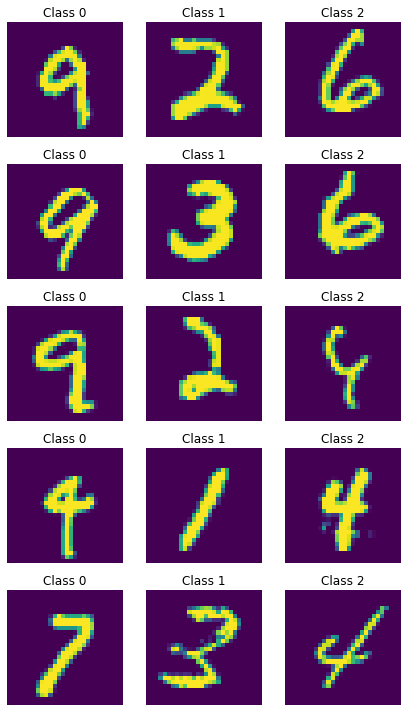

In [ ]:
# Visualization of X classes

# We give as input the test data, output shape, number of examples,
# and predicted labels

vis.viewImagesAndLabels(X_test, im_shape=(10,10), n_examples=5,
                        x_lbls=results_new['CauseClusterer']['x_lbls'])

In [ ]:
import matplotlib.patches as mpatches

'''
Helper function used to partition a list of probabilities
(CDE predictions) according to whether the true values are 
contained within certain classes called truth_variables. 
Returns a 2D array containing probabilites separated by 
membership of "truth" in "truth_variables".
'''
def partition(probs, truth, truth_variables):
    result = []
    for var in truth_variables:
        result.append(probs[np.isin(truth, var)])
    return np.array(result, dtype=object)

'''
Partitions predicted CDE probabilites along classes A, B, and C
'''
def partition_cause_class(probs, truth):
    return partition(probs, truth, [class_A, class_B, class_C])

'''
Partitions predicted CDE probabilites along labels 0, 1, and 2
'''
def partition_learned_cause(probs, truth):
    return partition(probs, truth, [[0],[1],[2]])

'''
Helper function to help with legend creation
'''
def patch(color):
    return mpatches.Patch(color=color)



#### Histogram

A CFL conditional density estimator (CDE) will take as input an image, and it will output the probability of belonging to a class. Below we plotted a histogram where the x-axis represents the the probability of belonging to class alpha, and the y-axis is the number of images that the CDE assigns to a given probability. Note that we show probabilities with respect to class alpha (also showing beta would be redundant because it is the complement).


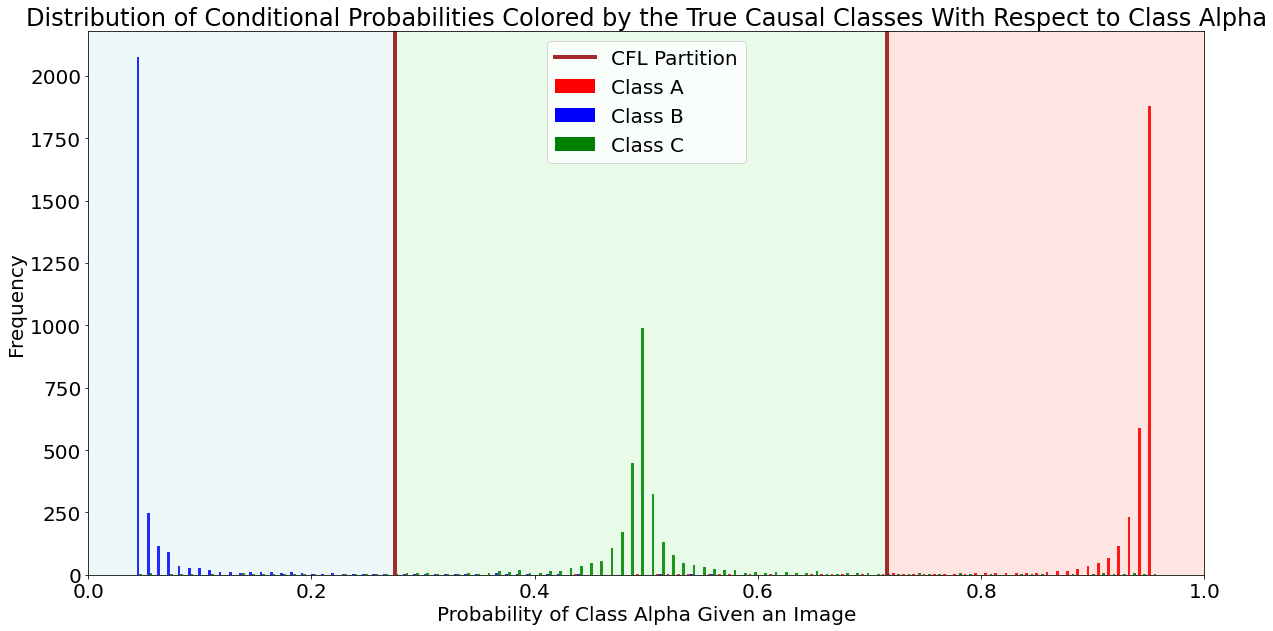

In [ ]:
# Stores the CDE output by CFL

pyx = results_new['CDE']['pyx']

'''
Code for plotting the histogram
'''
def make_plot():
    n_bins = 100
    cause_colors = ['red', 'blue', 'green']
    plt.rc('font', size=20)
    plt.figure(figsize=(20,10))
    plt.xlabel('Probability of Class Alpha Given an Image')
    plt.ylabel('Frequency')
    plt.title(
        'Distribution of Conditional Probabilities Colored by the '
        'True Causal Classes With Respect to Class Alpha')
    
#     Used to find CFL partition
    save_learned = partition_learned_cause(pyx[:][:, 0],
                        results_new['CauseClusterer']['x_lbls'])
    
    mins = sorted([min(x) for x in save_learned])
    maxes = sorted([max(x) for x in save_learned])
    partition1 = mins[1]
    partition2 = maxes[1]
    
    plt.axvline(x=partition1,color='brown', linewidth=4)

    plt.hist(partition_cause_class(pyx[:][:, 0], Y_test) , n_bins,
             histtype='bar', color=cause_colors, label=cause_colors)

    plt.legend(['CFL Partition', 'Class A', 'Class B', 'Class C'])

    plt.axvline(x=partition2, color='brown', linewidth=4)
    
    plt.axvspan(0, partition1, alpha=0.2, color='lightblue')
    
    plt.axvspan(partition1, partition2, alpha=0.2,
                color='lightgreen')
    
    plt.axvspan(partition2, 1, alpha=0.2, color='salmon')
    
    plt.xlim(0,1);

make_plot()


The brown lines and shaded regions reprented the causal classes that CFL has determined. The colors of the bars represent the true classes of the images in question. This is a stacked histogram with multiple bars on each interval, but to see the smaller bars more clearly we must plot the histogram on a log scale, as seen below. This scale allows us to observe cross contamination, i.e. images that CFL has predicted incorrectly.

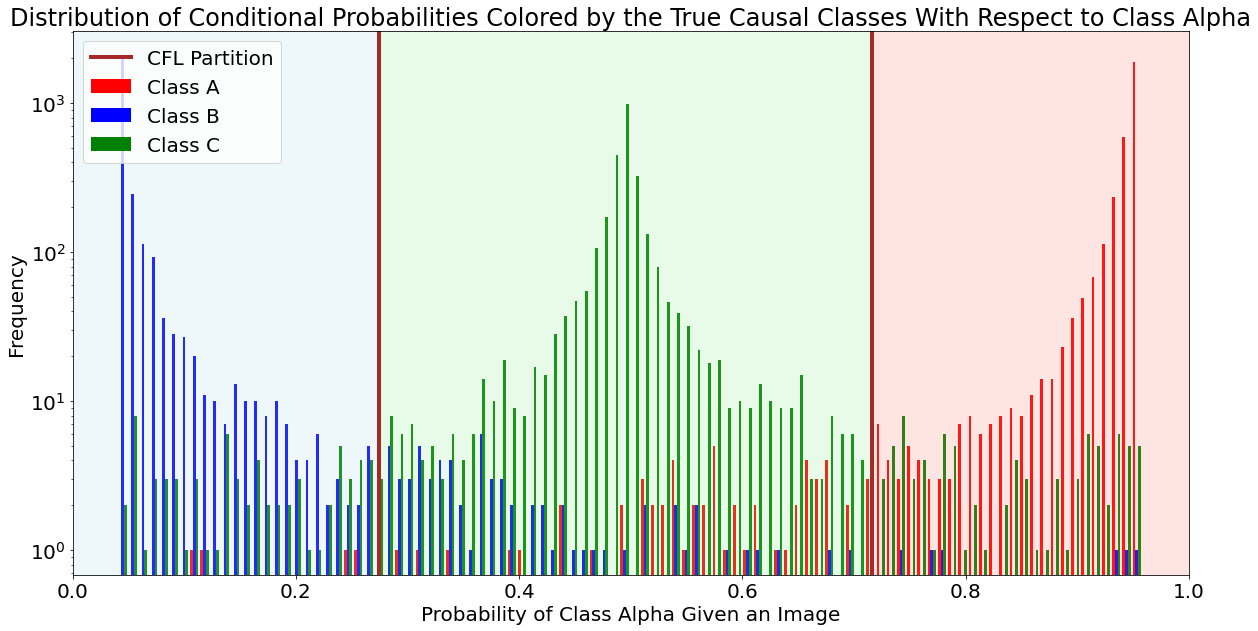

In [ ]:
make_plot()
plt.yscale('log')

### Quantifying Error

As we can see in the above graphs, CFL partitions the dataset accurately but not perfectly. We define two forms of error to quantify the success of CFL: distribution error and classification error. 


In [ ]:
'''
Given test data input, returns the correct CDE output
'''
def get_correct_dist(test_data):
    correct = []
    for val in test_data:
        true = get_distribution(val)
        correct.append(true[0])
    return np.array(correct)

'''
Returns the distribution error given a CDE and test data using
mean absolute error
'''    
def distribution_error(dist, test_data):
    correct = get_correct_dist(test_data)
    return np.mean(abs((dist - correct)))

In [ ]:
from itertools import permutations

'''
Converts a digit array into target classes encoded by
numbers 0, 1, and 2
'''
def target_map(y):
    if y in class_A:
        return 0
    elif y in class_B:
        return 1
    else:
        return 2

'''
Creates a dictionary mapping an initial set of labels to a 
different permutation of labels
'''
def createLabelsDict(labels, permutation):
    dic = {}
    for label, new_label in zip(labels, permutation):
        dic[label] = new_label
    return dic

'''
Returns percentage of correct labels given ground truth and a
specific labels mapping
'''
def accuracy(ground_truth, labels, mapping):
    correct = 0
    for truth, prediction in zip(ground_truth, labels):
        if truth == mapping[prediction]:
            correct += 1
    return correct / len(ground_truth)

'''
Checks all possible permutations of x_lbls against ground truth
labels and chooses the best one (highest degree of matches) as
the 'correct' mapping.
'''
def find_best_unique_mapping(ground_truth, x_lbls, lbl_set): 
    
    # permute x_lbls 
    all_possible_value_orders = list(permutations(lbl_set)) 
    
    # create dictionaries (mappings) with permuted x_lbls
    all_possible_mappings = [createLabelsDict(lbl_set,
                                permutation) for permutation in
                                all_possible_value_orders] 
    bestAccuracy = 0
    
    # iterate over all x_lbl mapping choices and evaluate their 
    # accuracy against ground truth 
    for mapping in all_possible_mappings: 
        
        #find accuracy 
        currentAcc = accuracy(ground_truth, x_lbls, mapping)
        
        # store mapping w best accuracy 
        if currentAcc > bestAccuracy: 
            bestAccuracy = currentAcc
            bestMapping = mapping
    return bestMapping, 1 - bestAccuracy


#### Distribution Error

Observe that had CFL found the causal classes perfectly, the CDE would only output probabilities 0.05, 0.5, and 0.95, and so we would expect three vertical bars in the histogram to reflect this. Distribution error simply measures the absolute difference between the learned distribution and the true distribution. For each image, it calculates the difference between the CDE output and the ground truth, then averages over all images.



In [ ]:
print('Distribution error: ', 
          distribution_error(
          results_new['CDE']['pyx'][:, 0], Y_test))

Distribution error:  0.029529148532106583


#### Classification Error

Classification error measures how accurately CFL makes predictions of the causal class against the ground truth. For example, CFL must predict that a 1 image is class A, 3 is class B, etc. Classification is the percentage that CFL predicts correctly. Because the learned CFL classes are arbitrary, we must compare against every permuation of labels on the ground truth, and the most generous error is the classification error.

These error measures differ in that distribution error aims to capture the error produced by the CDE. Classification error will be affected by the CDE and clustering accuracy.

In [ ]:
ground_truth = [target_map(y) for y in Y_test]

_, acc = find_best_unique_mapping(
    ground_truth, results_new['CauseClusterer']['x_lbls'], [0, 1, 2])

print('Classification Error: ', acc)

Causal clustering error:  0.032483370288248326
